In [1]:
import pandas as pd
import re
import torch
from torch.utils.data import Dataset
from itertools import chain 

In [2]:

import re

dtasets= ["train", "dev"]




data_={'train':{'id':[], 'labels':[], 'sentences':[]}, 
         'dev':{'id':[], 'labels':[], 'sentences':[]}}



In [3]:


for dta in dtasets:
        with open("train_dev/en-"+dta+".conll", 'r') as f:
            data=f.read()
            data=data.split('\n\n')
        
        lines=[]
        for lino in range(len(data)):
            lino=data[lino].split('\n')[1:]
            lines.append(lino)
            
        for line in lines:
            texts=[]
            labels=[]
            for index, word in enumerate(line):
                if index==0:
                    part=word.split()
                    data_[dta]['id'].append(part[2])
                
                else:
                    split_line=word.split('_')
                    split_line=[x.strip() for x in split_line]
                    split_line=list(filter(lambda x:x!="", split_line))
                    text, label = split_line
                    texts.append(text)
                    labels.append(label)
            
            data_[dta]['labels'].append(labels)
            data_[dta]['sentences'].append(texts)

In [4]:
lbs=data_['train']['labels']
sentnc=data_['train']['sentences']

In [5]:
import spacy
import torchtext

In [6]:
from transformers import BertTokenizerFast, BertModel


tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
model=BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
unique_labels=[]

for text in dtasets:
    for ner_labels in data_[text]['labels']:
        for label in ner_labels:
            unique_labels.append(label)

In [9]:
unique_labels=set(unique_labels) #67 labels
len(unique_labels)
#map each label to its representation and vice versa
labels_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(unique_labels))}

In [10]:

#We only provide a label to the first sub-word of each splitted token. The continuation of the sub-word then will simply have ‘-100’ as a label. All tokens that don’t have word_ids will also be labeled with ‘-100’.
#We provide the same label among all of the sub-words that belong to the same token. All tokens that don’t have word_ids will be labeled with ‘-100’
import torch


def align_label(texts, labels):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=30, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids


In [11]:
txt=[]

for i in sentnc:
    hello=''
    for j in i:
        hello+=j
        hello+=' '
    txt.append(hello)

In [12]:
from transformers import AutoModelForTokenClassification, Trainer

import numpy as np
import evaluate

from datasets import load_metric

metric=evaluate.load('seqeval')

def compute_metrics(p):
    predictions, labels=p
    predictions=np.argmax(predictions, axis=2)
    
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results=metric.compute(predictions=true_predictions, references=true_labels)
    flattenene_results={
        "overall_precision": results["overall_precision"],
        "overall_recall": results["overall_recall"],
        "overall_f1": results["overall_f1"],
        "overall_accuracy": results["overall_accuracy"],
    }
    
    #the following code allows us to see enity levelm trics
    
    for k in results.keys():
        if(k not in flattenene_results.keys()):
            flattenene_results[k+"_f1"]=results[k]["f1"]
            
    return flattenene_results
    


(array([1.000e+00, 0.000e+00, 7.000e+00, 4.500e+01, 2.480e+02, 1.270e+03,
        9.830e+02, 1.125e+03, 2.365e+03, 1.230e+03, 1.176e+03, 2.101e+03,
        9.960e+02, 1.705e+03, 7.050e+02, 6.000e+02, 9.700e+02, 3.740e+02,
        3.080e+02, 3.480e+02, 8.400e+01, 6.000e+01, 4.900e+01, 9.000e+00,
        8.000e+00, 7.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.  ,  1.36,  2.72,  4.08,  5.44,  6.8 ,  8.16,  9.52, 10.88,
        12.24, 13.6 , 14.96, 16.32, 17.68, 19.04, 20.4 , 21.76, 23.12,
        24.48, 25.84, 27.2 , 28.56, 29.92, 31.28, 32.64, 34.  , 35.36,
        36.72, 38.08, 39.44, 40.8 , 42.16, 43.52, 44.88, 46.24, 47.6 ,
        48.96, 50.32, 51.68, 53.04, 54.4 , 55.76, 57.12, 58.48, 59.84,
        61.2 , 62.56,

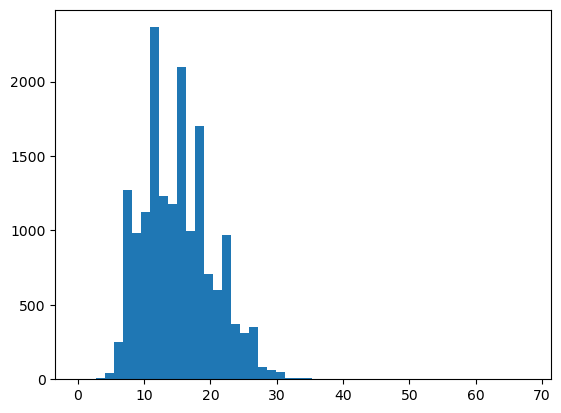

In [13]:
lengths=[len(sent) for sent in sentnc]
lengths

import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)

In [14]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
labels1=data_['dev']['labels']
sentences2=data_['dev']['sentences']
enclose=[]

for sentenc in sentences2:
    hi=''
    for wor in sentenc:
        hi+=wor
        hi+=' '
    enclose.append(hi)


In [15]:
tokens=tokenizer(txt, padding='max_length', max_length=30, truncation=True)
tokens2=tokenizer(enclose, padding='max_length', max_length=30, truncation=True)

In [16]:



class DataSequence(torch.utils.data.Dataset):
    
    def __init__(self, tokos, label, sentence_use):  
        self.tokens=tokos 
        self.labels=[align_label(i,j) for i,j in zip(sentence_use, label)]
   
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, indx):
        item ={key: torch.tensor(val[indx]) for key, val in self.tokens.items()}
        item['labels']=torch.tensor(self.labels[indx])
        return item

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')    
train=DataSequence(tokens, lbs, txt)    
val=DataSequence(enclose, labels1, enclose)

model2=model2.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
train

In [ ]:
train_ds=dm.

In [24]:
import re
def get_tokens_with_entities(raw_text: str):
    # split the text by spaces only if the space does not occur between square brackets
    # we do not want to split "multi-word" entity value yet
    raw_tokens = re.split(r"\s(?![^\[]*\])", raw_text)

    # a regex for matching the annotation according to our notation [entity_value](entity_name)
    entity_value_pattern = r"\[(?P<value>.+?)\]\((?P<entity>.+?)\)"
    entity_value_pattern_compiled = re.compile(entity_value_pattern, flags=re.I|re.M)

    tokens_with_entities = []

    for raw_token in raw_tokens:
        match = entity_value_pattern_compiled.match(raw_token)
        if match:
            raw_entity_name, raw_entity_value = match.group("entity"), match.group("value")

            # we prefix the name of entity differently
            # B- indicates beginning of an entity
            # I- indicates the token is not a new entity itself but rather a part of existing one
            for i, raw_entity_token in enumerate(re.split("\s", raw_entity_value)):
                entity_prefix = "B" if i == 0 else "I"
                entity_name = f"{entity_prefix}-{raw_entity_name}"
                tokens_with_entities.append((raw_entity_token, entity_name))
        else:
            tokens_with_entities.append((raw_token, "O"))

    return tokens_with_entities



print(get_tokens_with_entities("I come from [Kathmandu valley,](location) [Nepal](location)"))




[('I', 'O'), ('come', 'O'), ('from', 'O'), ('Kathmandu', 'B-location'), ('valley,', 'I-location'), ('Nepal', 'B-location')]


In [25]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# note that I purposefully misspell Kathmandu to Kathamanduu
sample_input = "I come from [Kathmanduu valley,](location) [Nepal](location)"
tokens, entities = list(zip(*get_tokens_with_entities(sample_input)))
tokenized_input = tokenizer(tokens, is_split_into_words=True)
print("Original tokens           : ", tokens)
print("After subword tokenization: ", tokenizer.convert_ids_to_tokens(tokenized_input['input_ids']))
# Original tokens           :  ('I', 'come', 'from', 'Kathmanduu', 'valley,', 'Nepal')
# After subword tokenization:  ['[CLS]', 'i', 'come', 'from', 'kathmandu', '##u', 'valley', ',', 'nepal', '[SEP]']

Original tokens           :  ('I', 'come', 'from', 'Kathmanduu', 'valley,', 'Nepal')
After subword tokenization:  ['[CLS]', 'i', 'come', 'from', 'kathmandu', '##u', 'valley', ',', 'nepal', '[SEP]']


In [26]:
raw_text = """
[40"](display_size) [LED](display_type) TV
Specifications: [16″](display_size) HD READY [LED](display_type) TV.
[1 Year](warranty) Warranty
Rowa [29"](display_size) [LED](display_type) TV
Highlights:- 48"Full HD [LED](display_type) TV Triple Protection
[80cm](display_size) (32) HD Flat TV K4000 Series 4
[32"](display_size) LED, [2 yrs](warranty) full warranty, All care protection, Integrated Sound Station- Tweeter/20w, Family tv 2.0, Louvre Desing, Mega dynamic contract ratio, Hyper real engine, USB movie
CG 32D0003 [LED](display_type) TV
Screen Size : [43″](display_size)
Resolution : 1920*1080p
Response time : [8ms](response_time)
USB : Yes (Music+Photo+Movie)
Analog AV Out : Yes
Power Supply : 110~240V 50-60Hz
WEGA [32 Inch](display_size) SMART DLED TV HI Sound Double Glass - (Black)
Model: [32"](display_size) Smart DLED TV HI Sound
Hisense HX32N2176 [32"Inch](display_size) Full HD [Led](display_type) Tv
[32 Inch](display_size) [1366x768](display_resolution) pixels HD LED TV
[43 inch](display_size) [LED](display_type) TV
[2 Years](warranty) Warranty & 1 Year Service Warranty
[1920 X 1080](display_resolution) Full HD
[Technos](brand) [39 Inch](display_size) Curved Smart [LED](display_type) TV E39DU2000 With Wallmount
24″ Led Display Stylish Display Screen resolution : [1280 × 720](display_resolution) (HD Ready) USB : Yes VGS : Yes
Technos 24K5 [24 Inch](display_size) LED TV
Technos Led Tv [18.5″ Inch](display_size) (1868tw)
[18.5 inch](display_size) stylish LED dsiplay [1280 x 720p](display_resolution) HD display 2 acoustic speaker USB and HDMI port Technos brand
15.6 ” Led Display Display Screen resolution : 1280 720 (HD Ready) USB : Yes VGS : Yes HDMI : Yes Screen Technology : [led](display_type)
Model:CG55D1004U
Screen Size: [55"](display_size)
Resolution: [3840x2160p](display_resolution)
Power Supply: 100~240 V/AC
Sound Output (RMS): 8W + 8W
Warranty: [3 Years](warranty) wrranty
"""

dm = NERDataMaker(raw_text.split("\n"))
print(f"total examples = {len(dm)}")
print(dm[0:3])

# total examples = 35
# [{'id': 0, 'ner_tags': [0], 'tokens': ['']}, {'id': 1, 'ner_tags': [2, 3, 0], 'tokens': ['40"', 'LED', 'TV']}, {'id': 2, 'ner_tags': [0, 2, 0, 0, 3, 0], 'tokens': ['Specifications:', '16″', 'HD', 'READY', 'LED', 'TV.'

NameError: name 'NERDataMaker' is not defined

In [27]:
from datasets import Dataset